### TODO
- [ ] Make the model case unsensitive
- [ ] Clean the code

In [120]:
import numpy as np
import pandas as pd
from data import get_train_test_split
from models.utils import damerau_levenshtein_distance, regexp_processing
from tqdm import tqdm
from collections import Counter

import seaborn as sns

In [121]:
class KNN:
    def __init__(self, k, classes):
        """
        Args:
            k (int): number of nearst neighbours to consider
            classes (list): list of output classes
        """
        self.k = k
        self.destinations = {}
        self.classes = {label: 0 for label in classes}
    
    def fit(self, dataset):
        for i in range(len(dataset)):
            self.destinations[dataset.iloc[i]["destination"]] = dataset.iloc[i]["code"]
    
    def eval(self, dataset):
        """Evaluates the model on dataset
        
        Args:
            dataset (DataFrame): needs to have columns "destination" and "code" (i.e label)
        
        Returns:
            accuracy (float): the percentage of correct labels
        """
        
        correct = 0
        false_preds = []
        for i in range(len(dataset)):
            text = dataset.iloc[i]["destination"]
            label = dataset.iloc[i]["code"]
            pred,_,_ = self(text)
            if pred == label: correct += 1
            else: false_preds.append((text, pred, label))

        return correct / len(dataset), false_preds
    
    @staticmethod
    def max_distance(text, elements):
        """Find the farthest element and returns its index
        Args:
            text (str): text to consider
            elements (double<str>): (destination, label)
        
        Returns:
            int: index of the farthest element
        """
        max_idx = 0
        max_distance = damerau_levenshtein_distance(text, elements[0][0])
        for i in range(1, len(elements)):
            if damerau_levenshtein_distance(text, elements[i][0]) > max_distance: 
                max_idx = i
                max_distance = damerau_levenshtein_distance(text, elements[i][0])
        return max_idx

    @staticmethod
    def alt_softmax(counter):
        denominator = sum([np.exp(y)*y for y in counter.values()])
        for key in counter.keys():
            counter[key] = np.exp(counter[key])*counter[key] / denominator
        
        return counter
    
    
    def __call__(self, text):
        """Classify text with the most common label amongst k-nearest neighbours
        
        Args:
            text (str): text to label
        
        Returns:
            label(str): the predicted label
            nearest_neighbours (list): list of k-nearest neighbours (from the training data)
        """
        
        nearest_neighbours = []
        for destination, label in self.destinations.items():
            if len(nearest_neighbours) < self.k: nearest_neighbours.append((destination, label))
            else:
                worst_neighbour_idx = self.max_distance(text, nearest_neighbours)
                nearest_neighbours[worst_neighbour_idx] = (destination, label)
        
        # find the best label
        label_counts = Counter([nn[1] for nn in nearest_neighbours])
        
        label_counts = self.alt_softmax(label_counts)
        for label in self.classes.keys():
            self.classes[label] = label_counts[label]
        
        return label_counts.most_common()[0][0], self.classes, nearest_neighbours

In [122]:
train, test = get_train_test_split("10_ports.csv")

In [123]:
classes = train["code"].unique().tolist()

In [124]:
model = KNN(k=4, classes=classes)

In [125]:
model.fit(train)

In [87]:
model.eval(test)

(0.92,
 [('ST.MALO/FRANCE.', 'FRBES', 'FRSML'),
  ('FRBOD', 'FRMTX', 'FRBOD'),
  ('FR BES > PT LEI', 'FRMTX', 'FRBES'),
  ('FR DON > FR LEH', 'FRMTX', 'FRLEH')])

In [88]:
model("Rotterdam")

('NLRTM',
 {'FRBES': 0,
  'ESSDR': 0.13447071068499755,
  'NLRTM': 0.7310585786300049,
  'BEANR': 0,
  'FRLEH': 0,
  'FRSML': 0,
  'ESBIO': 0,
  'FRMTX': 0.13447071068499755,
  'FRIRK': 0,
  'FRBOD': 0},
 [('ROTTERAM', 'NLRTM'),
  ('MONTOIR  FRANCE', 'FRMTX'),
  ('SANTANDER', 'ESSDR'),
  ('ROTTERDAM', 'NLRTM')])

100%|██████████| 6/6 [00:27<00:00,  4.65s/it]


[Text(0.5, 1.0, 'Accuracy'),
 Text(0.5, 0, 'k parameter'),
 Text(0, 0.5, 'Accuracy')]

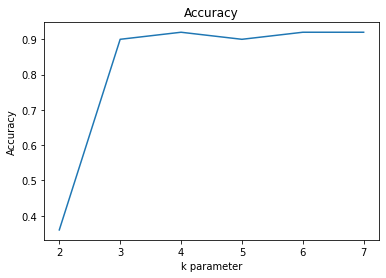

In [91]:
accuracies = []

for k in tqdm(range(2, 8)):
    model = KNN(k=k, classes=classes)
    model.fit(train)
    acc,_ = model.eval(test)
    
    accuracies.append(acc)

sns.lineplot(x=range(2,8), y=accuracies).set(title="Accuracy", xlabel="k parameter", ylabel="Accuracy")

100%|██████████| 198/198 [00:00<00:00, 4292.71it/s]

100%|██████████| 198/198 [00:00<00:00, 4419.07it/s]

100%|██████████| 198/198 [00:00<00:00, 4364.61it/s]

100%|██████████| 198/198 [00:00<00:00, 4502.11it/s]

100%|██████████| 198/198 [00:00<00:00, 4358.82it/s]

100%|██████████| 198/198 [00:00<00:00, 4351.26it/s]

100%|██████████| 6/6 [00:16<00:00,  2.69s/it]


[Text(0.5, 1.0, 'Accuracy'),
 Text(0.5, 0, 'k parameter'),
 Text(0, 0.5, 'Accuracy')]

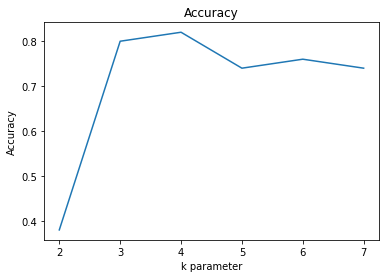

In [7]:
## SAME BUT WITH PROCESSED DATA

train_df, test_df = get_train_test_split("10_ports.csv", transform=regexp_processing)

accuracies = []

for k in range(2, 8):
    model = KNN(k=k, classes=classes)
    model.fit(train_df)
    acc,_ = model.eval(test_df)
    
    accuracies.append(acc)

sns.lineplot(x=range(2,8), y=accuracies).set(title="Accuracy", xlabel="k parameter", ylabel="Accuracy")

In [107]:
model = KNN(k=4, classes=classes)
model.fit(train)

correct = 0
false_preds = []
for i in tqdm(range(len(train))):
    text = train.iloc[i]["destination"]
    label = train.iloc[i]["code"]
    pred,_,_ = model(text)
    if pred == label: correct += 1
    else: false_preds.append((text, pred, label))

(correct / len(train), false_preds)

100%|██████████| 198/198 [00:15<00:00, 12.66it/s]


(0.9646464646464646,
 [('SE BRO > FR BOD', 'FRMTX', 'FRBOD'),
  ('FR BOD > RU PRI', 'FRBES', 'FRBOD'),
  ('ESBIO > NLTNZ', 'NLRTM', 'ESBIO'),
  ('FR BOD', 'FRBES', 'FRBOD'),
  ('FRBOD>DEHAM', 'NLRTM', 'FRBOD'),
  ('NL RTM > FR NTE', 'FRMTX', 'NLRTM'),
  ('ANTWERP FOR ORDERS', 'NLRTM', 'BEANR')])

In [128]:
model("FRBES")

('FRBES',
 {'FRBES': 0.9568354670200037,
  'ESSDR': 0,
  'NLRTM': 0,
  'BEANR': 0,
  'FRLEH': 0,
  'FRSML': 0,
  'ESBIO': 0,
  'FRMTX': 0.043164532979996256,
  'FRIRK': 0,
  'FRBOD': 0},
 [('FRBES', 'FRBES'),
  ('MONTOIR  FRANCE', 'FRMTX'),
  ('FR BES', 'FRBES'),
  ('AMBES', 'FRBES')])